# Sinergise Summer School 2022

## EO Research Team ML part I


Welcome! This notebook will show you the guts of the satellite data, with a focus on wildfires. We will be working with Sentinel-2 L2A data and explore how this data can be utilized in order to automatically recognize affected areas.

### Observing wildfire-affected areas in EO Browser

Let's first jump into EO Browser to see how a wildfire can affect land surface: https://sentinelshare.page.link/g4vL

Things to observe:
- before/after
- other layers (NDVI, NBR)
- show timelapse
- show NDVI statistics

### How to work with satellite data offline?

The data can be structured in a complex format, as you have multi-dimensional arrays which can cause headaches - you have the temporal dimension, 2 spatial dimensions, or even additional ones, such as the spectral bands (<span style="color:red;">red</span>, <span style="color:green;">green</span>, <span style="color:blue;">blue</span>, ...).

![image_slices](https://miro.medium.com/max/1400/1*oEQIFQke_8ETQvvD-qCBYA.png)

In order to have a convenient access to this data, we have developed a specific contained called an `EOPatch`, which is basically a dictionary containing different types of data we will be working with, mostly:
- `DATA`: Sentinel 2 bands
- `MASK`: Area affected by wildfire

![eopatch_container](https://miro.medium.com/max/1400/1*pTOOYBGAmCrfLy5zOLKY9g.png)

### Loading EOPatches

Let's load our first eopatch from the AWS S3 bucket and show it's structure

In [1]:
from eolearn.core import EOPatch

# download from AWS S3 bucket
eop_path = "../data/eopatch_1"
eop = EOPatch.load(eop_path)
eop

EOPatch(
  data={
    B01: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B02: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B03: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B04: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B05: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B06: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B07: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B08: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B09: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B11: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B12: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    B8A: numpy.ndarray(shape=(2, 300, 300, 1), dtype=float32)
    CLP: numpy.ndarray(shape=(2, 300, 300, 1), dtype=uint8)
  }
  mask={
    CLM: numpy.ndarray(shape=(2, 300, 300, 1), dtype=uint8)
    dataMask: numpy.ndarray(shape=(2, 300, 300, 1), dtype=bool)
  }
  mask_timeless={
    BURN_AREA: nump

These eopatches have 2 timestamps which correspond to the `before` and `after` the wildfire occurred. The `eop.data` contains information about the Sentinel-2 L2A bands. Other "bands" mean the following:
- `CLP`: cloud probabilities for each timestamp
- `CLM`: cloud masks (threshold over the probabilities + image postprocessing) for each timestamp
- `dataMask`: mask showing information where data is available for each timestamp
- `BURN_AREA`: a timeless mask showing the extent of the burned area (no timestamps)

The dimensions of the features go like this `(t, h, w, d)`, where:
- `t`: size of temporal dimension (number of timestamps)
- `h`: height
- `w`: width
- `d`: depths (number of bands)

### How to extract data from the eopatches?

Extracting data is as easy as accessing values from a dictionary. Let's extract the <span style="color:red;">red</span>, <span style="color:green;">green</span>, and <span style="color:blue;">blue</span> bands in order to construct a true-color (<span style="color:red;">R</span><span style="color:green;">G</span><span style="color:blue;">B</span>) image.

Check the following links for more information about the bands:
- https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data
- https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# load bands
red = eop.data["B04"]
green = eop.data["B03"]
blue = eop.data["B02"]

# print out the shapes
print(f'Shape of "red": {red.shape}')
print(f'Shape of "green": {green.shape}')
print(f'Shape of "blue": {blue.shape}')

Shape of "red": (2, 300, 300, 1)
Shape of "green": (2, 300, 300, 1)
Shape of "blue": (2, 300, 300, 1)


### How to plot the satellite data?

#### Plotting single bands

(300, 300, 1)


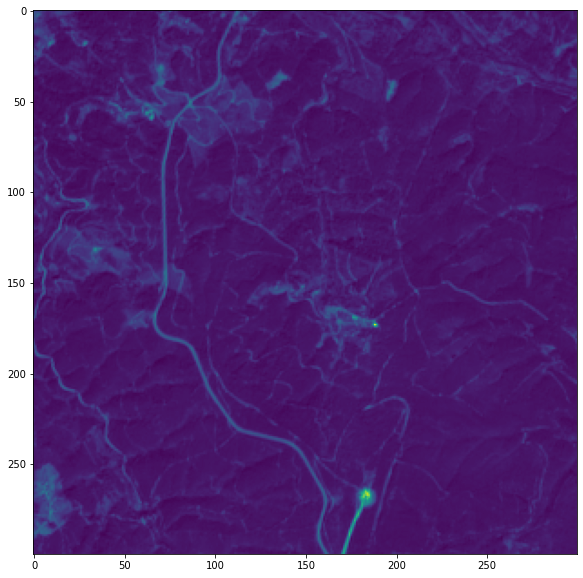

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

# needs to be of shape (h, w) or (h, w, 1) - plot for single time!
image_to_display = green[0]
print (image_to_display.shape)
ax.imshow(image_to_display)

#### Plotting the RGB bands

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of "RGB": (2, 300, 300, 3)


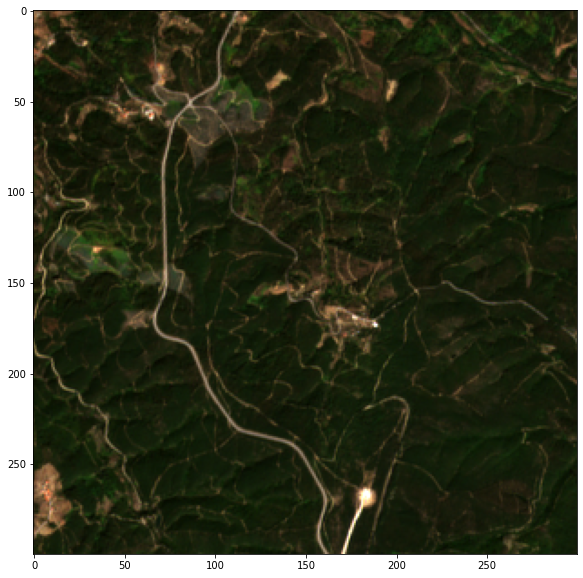

In [17]:
brightness_factor = 3.5

# concatenate the r, g, b into RGB using `np.concatenate`
rgb = np.concatenate([red, green, blue], axis =-1)
print(f'Shape of "RGB": {rgb.shape}')

# needs to be of shape (h, w, 3) - plot for single time!
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb[0] * brightness_factor)

#### Plotting the mask

(300, 300, 1)


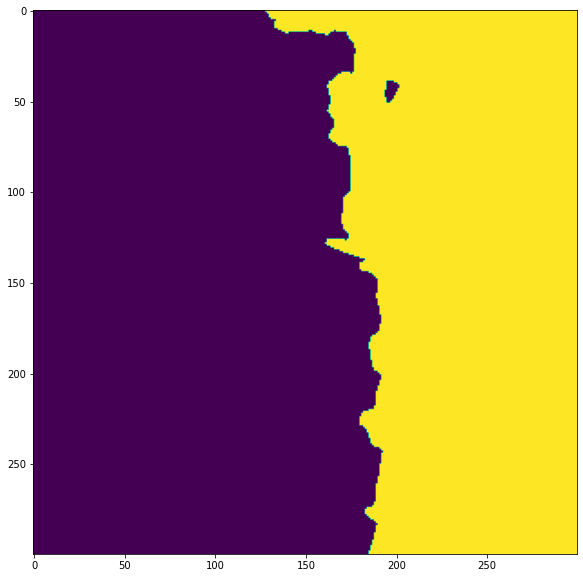

In [20]:
mask = eop.mask_timeless["BURN_AREA"]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask)
print(mask.shape)

#### Putting it all together

False-Color is better at showing vegetation and non-vegetation than True-Color. Let's now plot False-Color for before and after

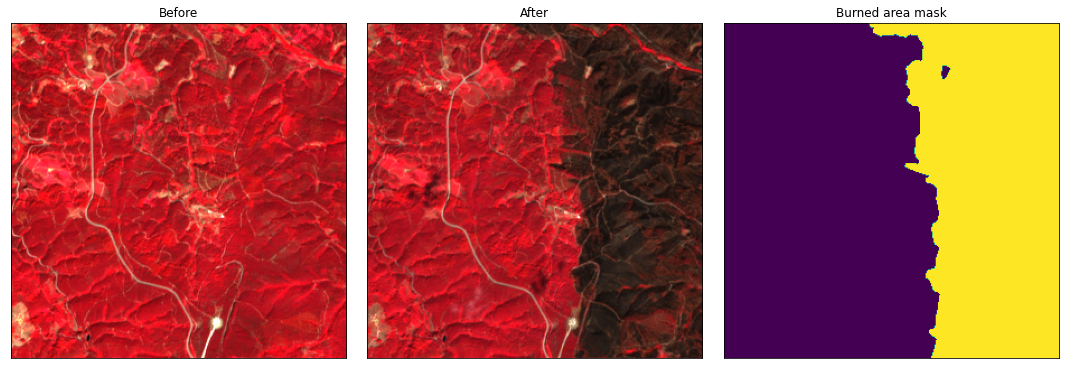

In [24]:
# import existing tool for ease of plotting
from utils import plot_combo

# plotting False-Color - (Near-Infrared, Red, Green) -> (B08, B04, B03)
nir = eop.data["B08"]
fc = np.concatenate([nir, red, green], axis=-1)
plot_combo(fc, mask=mask, brightness_factor=3.5, clip=(0, 1))

### Calculating additional features

Using raw bands is oftentimes completely sufficient. However, sometimes a combination of bands sends a message across in a more efficient manner. One of such combinations is the `Normalized Difference Vegetation Index`, or `NDVI`, which is a normalized metric for how much vegetation covers the surface. It spans from -1 to 1, from low- to high vegetation, respectively.

Here is the formula to calculate NDVI:

$$
NDVI = \frac{B_{08} - B_{04}}{B_{08}+B_{04}} = \frac{NIR - Red}{ NIR + Red}
$$

Try to use the `numpy` arrays to create the `NDVI` feature and append it to the `EOPatch`.

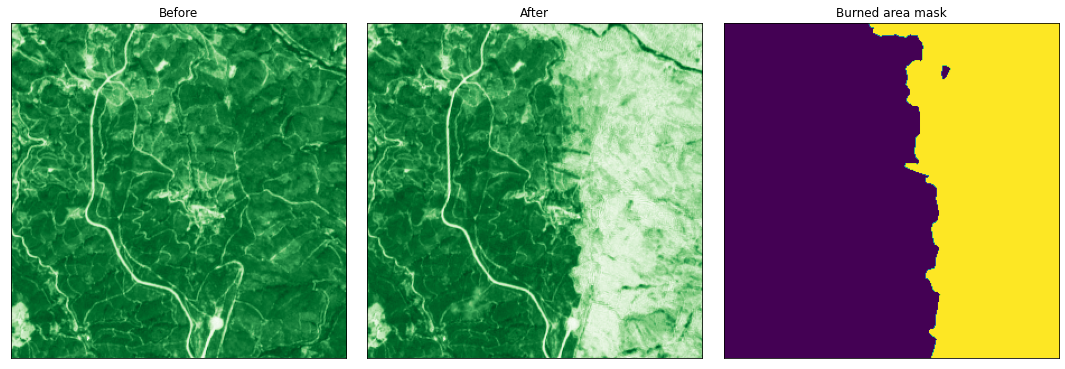

In [28]:
ndvi = (nir - red) / (nir + red)
plot_combo(ndvi, mask=mask, cmap=plt.cm.Greens)

Another one is the `Normalized Burn Ratio`, or `NBR`. It is calculated in a similar manner, where lower values represent burned areas.

$$
NBR = \frac{B_{08} - B_{12}}{B_{08}+B_{12}} = \frac{NIR - SWIR}{NIR + SWIR}
$$

The $B_{12}$ band has a lower resolution of 20 m, which is also visible on the output map.

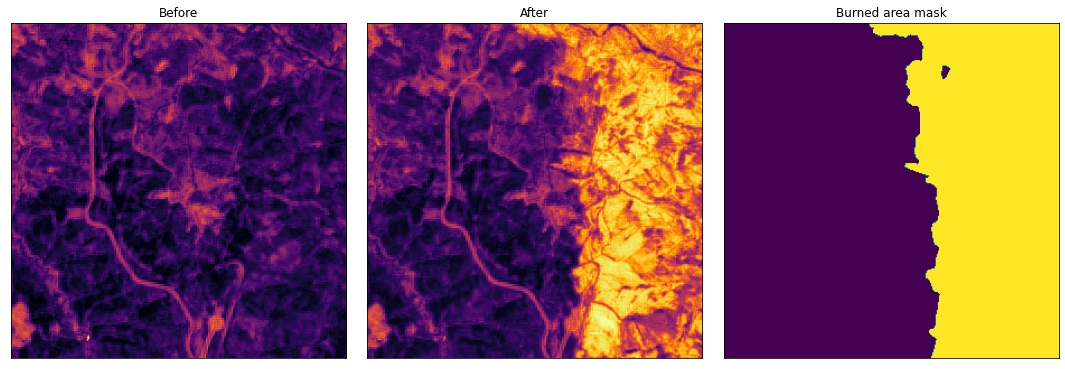

In [30]:
swir = eop.data["B12"]
nbr = ((nir - swir) / (nir+swir))
plot_combo(nbr, mask=mask, cmap=plt.cm.inferno_r)

### Exploring the values on the pixel-level

We have prepared a table of values in the ML-ready format for us to explore. This will better help us understand the nature of the features from the burned and non-burned areas from the statistical point of view.

A dataframe is constructed from the `pandas` python package, which is a convenient representation of a large dataset. `pandas` also enables easy manipulation of the data, which comes in handy.

In [31]:
import pandas as pd

# download from AWS S3 bucket
df_path = "../data/wildfires_single_scene_training_dataset.parquet"
df = pd.read_parquet(df_path)

# show content
df

,EOPATCH,TIMESTAMP,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,BURN_AREA
5606138,eopatch_70,2020-07-21,0.0445,0.0364,0.0628,0.0665,0.1143,0.1888,0.2206,0.2591,0.2456,0.2531,0.2524,0.1524,0
2949385,eopatch_8,2020-08-28,0.0066,0.0162,0.0328,0.0216,0.0580,0.1490,0.1747,0.1854,0.1913,0.1809,0.0930,0.0437,0
2550676,eopatch_6,2020-08-28,0.0071,0.0092,0.0392,0.0223,0.0698,0.2158,0.2586,0.2679,0.2713,0.2573,0.0871,0.0355,0
2721767,eopatch_1,2020-08-28,0.0094,0.0212,0.0521,0.0578,0.1114,0.1761,0.1933,0.1925,0.2238,0.2116,0.1803,0.1082,0
10585791,eopatch_26,2020-08-09,0.0334,0.0332,0.0539,0.0526,0.1051,0.1542,0.1918,0.1982,0.2079,0.2008,0.2637,0.1697,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713208,eopatch_62,2020-07-09,0.0568,0.0650,0.0706,0.0872,0.1021,0.1072,0.1110,0.1074,0.1184,0.1214,0.2101,0.2402,1
5180599,eopatch_15,2020-09-19,0.0192,0.0250,0.0284,0.0379,0.0458,0.0488,0.0486,0.0607,0.0579,0.0928,0.1174,0.1324,1
10933580,eopatch_10,2020-09-19,0.0127,0.0202,0.0255,0.0383,0.0541,0.0673,0.0812,0.0802,0.0910,0.0793,0.0933,0.0719,1
2823255,eopatch_1,2020-09-19,0.0062,0.0137,0.0195,0.0262,0.0361,0.0488,0.0483,0.0543,0.0616,0.0976,0.0638,0.0544,1


In [32]:
# count number of different eopatches
df.EOPATCH.nunique()

71

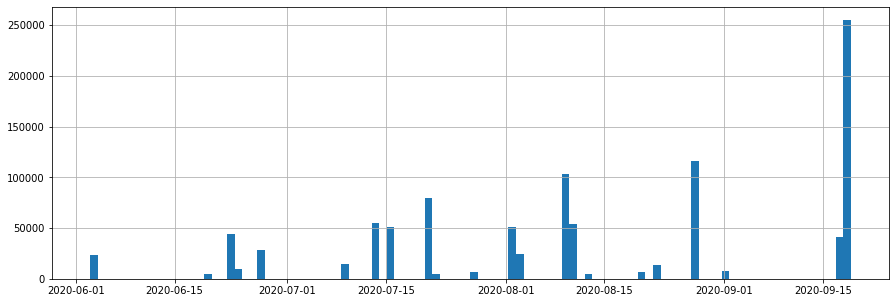

In [33]:
# plot histogram of timestamps
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df.TIMESTAMP, bins=100)
ax.grid("on")

In [34]:
# count pixels from each class
df.BURN_AREA.value_counts()

0    500000
1    500000
Name: BURN_AREA, dtype: int64

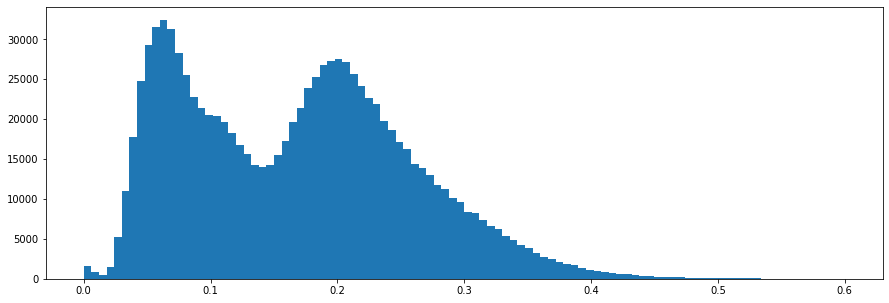

In [38]:
_, ax = plt.subplots(figsize=(15, 5))

# plot histogram of B08 values
band_values = df.B08
ax.hist(band_values, range=(0, 0.6), bins=100);

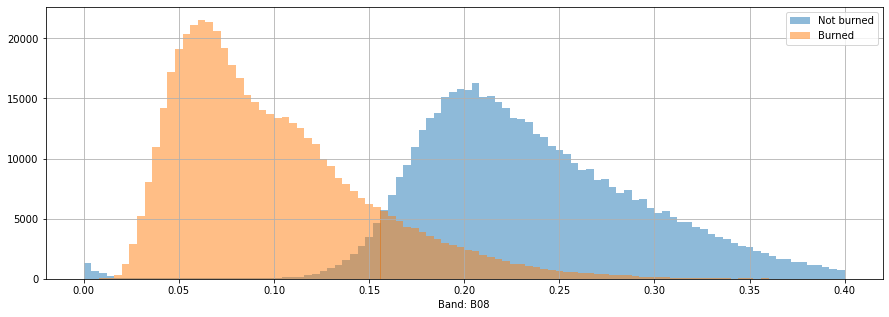

In [39]:
# existing tool from utils for ease of use
from utils import plot_band_hist

# plot histogram of one band for both classes
plot_band_hist(df, "B08", bins=100, range=(0, 0.4))

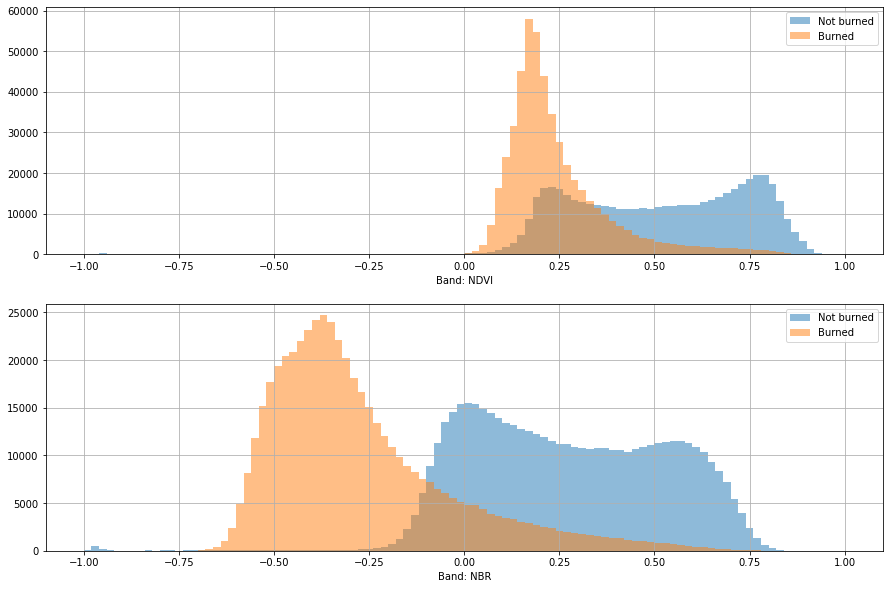

In [43]:
# How about NDVI and NBR?
df["NDVI"] = ((df.B08-df.B04)/(df.B08+df.B04))
df["NBR"] = ((df.B08-df.B12)/(df.B08+df.B12))

fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

plot_band_hist(df, "NDVI", bins=100, range=(-1, 1), ax=axs[0])
plot_band_hist(df, "NBR", bins=100, range=(-1, 1), ax=axs[1])

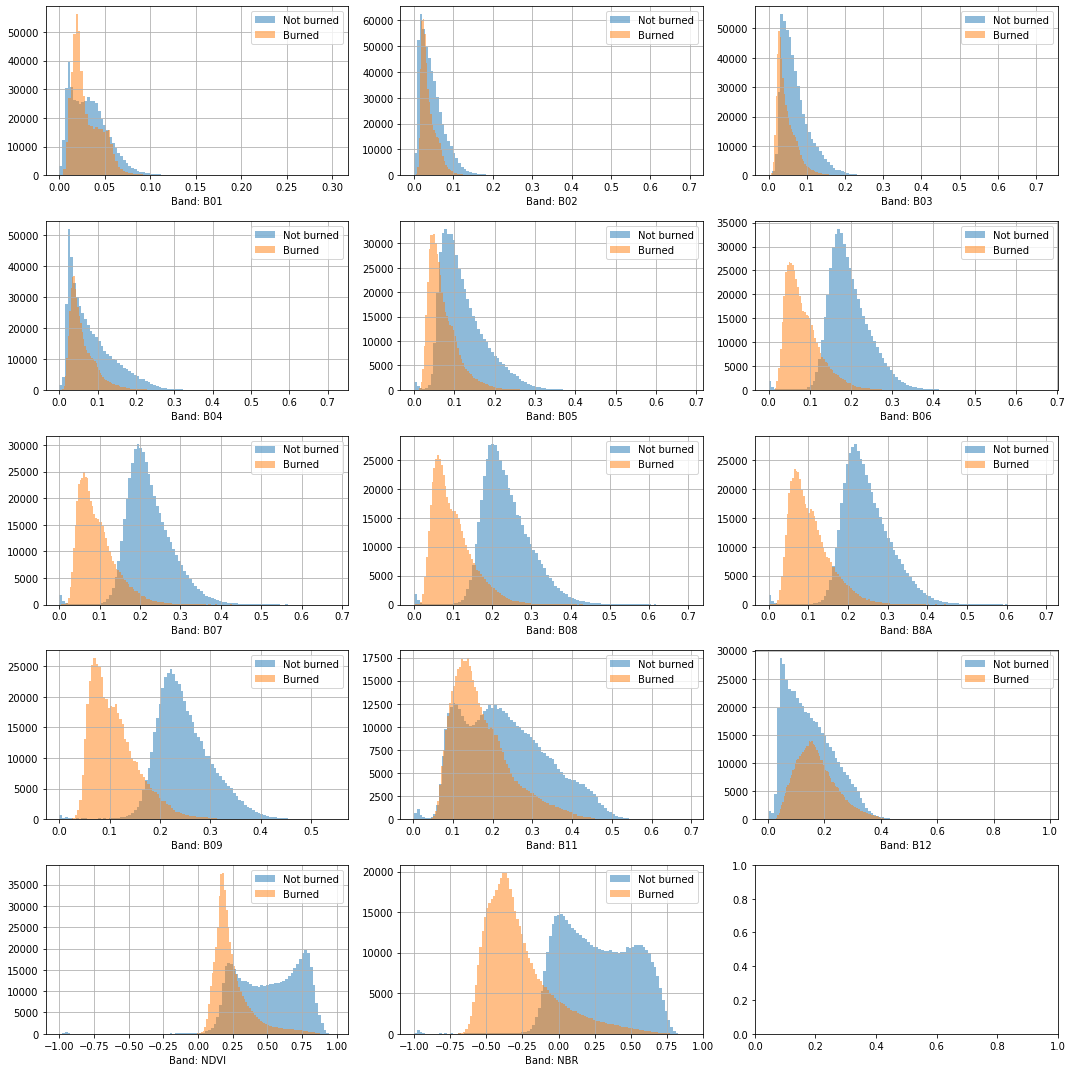

In [48]:
# plot for all

features = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B11",
    "B12",
    "NDVI",
    "NBR",
]

ncols = 3
nrows = int(np.ceil(len(features) / ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 3 * nrows))

for idx, feature in enumerate(features):
    ax = axs[idx // ncols][idx % ncols]
    plot_band_hist(df, feature, bins=100, ax=ax)

plt.tight_layout()

In [49]:
import seaborn as sns

compare = ["B10", "B06", "B07", "B08", "B09", "BURN_AREA"]
sample = df.sample(frac=0.001)

sns.pairplot(sample[compare], hue="BURN_AREA", plot_kws=dict(marker="+", linewidth=1))

KeyError: "['B10'] not in index"